---
title: "Data processing in TIMSImaging"
execute:
  warning: false
  message: false
output:
  html_document: default
---

## Introcution
In this part, we start from raw .d data, explore the dataset, perform peak processing, show separation by ion mobility and export the results in the open imzML format.

In [1]:
import timsimaging

# enable visualization in the Jupyter notebook
from bokeh.io import show, output_notebook
output_notebook()
# disable FutureWarning
import warnings
warnings.filterwarnings('ignore')

Loading BokehJS ...

### Load MALDI-TIMS-TOF raw data
Suppose we know nothing about this dataset. First we load the dataset and print basic information like pixel number and data range.

In [2]:
bruker_d_folder_name = r"D:\dataset\Kidney_MS1_ITO6.d"
dataset = timsimaging.spectrum.MSIDataset(bruker_d_folder_name)
dataset

100%|██████████████████████████████████████████████████████████████████████████| 38267/38267 [00:23<00:00, 1647.76it/s]


MSIDataset with 38267 pixels
        mz range: 799.998-2500.007
        mobility range: 1.200-2.600
        

### View summary image and tables

Then we can view the TIC image without any processing, as the TIC intensities are stored in the `Frames` table in the raw tdf file. Hover on individual pixels to see the details like coordinates and intensity:

In [3]:
dataset.image()

We can view the underlying data as tables, too

In [4]:
# pixel positions
dataset.pos

XIndexPos  YIndexPos
Frame                      
1            336        175
2            337        175
3            338        175
4            339        175
5            340        175
...          ...        ...
38263        737        116
38264        738        116
38265        739        116
38266        740        116
38267        741        116

[38267 rows x 2 columns]

In [5]:
# metadata of pixels
dataset.data.frames

Id          Time  ScanMode  MsMsType       TimsId  MaxIntensity  \
0          0      0.000000        20         0           64             0   
1          1      2.671587        20         0           64           688   
2          2      2.941060        20         0       210641           637   
3          3      3.210677        20         0       407604           605   
4          4      3.480285        20         0       595229           626   
...      ...           ...       ...       ...          ...           ...   
38263  38263  10602.755832        20         0  11938087511           925   
38264  38264  10603.025466        20         0  11938264725           720   
38265  38265  10603.295060        20         0  11938440038           775   
38266  38266  10603.564667        20         0  11938622040           626   
38267  38267  10603.813145        20         0  11938802286           755   

       SummedIntensities  NumScans  NumPeaks  MzCalibration         T1  \
0                      0      1212         0              1  25.630815   
1                5346970      1212     76165              1  25.630815   
2                4998845      1212     71095              1  25.630815   
3                4793642      1212     67948              1  25.630815   
4                4705085      1212     66534              1  25.630938   
...                  ...       ...       ...            ...        ...   
38263            4587513      1212     64378              1  25.666533   
38264            4511870      1212     63215              1  25.666508   
38265            4700548      1212     66076              1  25.666508   
38266            4648396      1212     65487              1  25.666508   
38267            4574022      1212     63950              1  25.666508   

              T2  TimsCalibration  PropertyGroup  AccumulationTime  RampTime  \
0      23.592239                1              1             59.47    230.09   
1      23.592239                1              1             59.47    230.09   
2      23.592239                1              1             59.47    230.09   
3      23.592239                1              1             59.47    230.09   
4      23.591317                1              1             59.47    230.09   
...          ...              ...            ...               ...       ...   
38263  23.497069                1              1             59.47    230.09   
38264  23.496083                1              1             59.47    230.09   
38265  23.496083                1              1             59.47    230.09   
38266  23.496083                1              1             59.47    230.09   
38267  23.496083                1              1             59.47    230.09   

       Pressure  Denoised  
0      2.055982         0  
1      2.055982         0  
2      2.055982         0  
3      2.055982         0  
4      2.055983         0  
...         ...       ...  
38263  2.055988         0  
38264  2.055988         0  
38265  2.055988         0  
38266  2.055988         0  
38267  2.055988         0  

[38268 rows x 18 columns]

### Set region of interest(ROI)
The left region is the kidney tissue, we can use the `set_ROI` method to set the ROI by `xmin`, `xmax`, `ymin`, `ymax` parameters.

In [6]:
dataset.set_ROI(name='kidney', xmax=500)

### Process selected ROI
Then we run the processing pipline introduced in the basic use notebook.

In [7]:
results = dataset.process(sampling_ratio=0.1, frequency_threshold=0.02, tolerance=3, adaptive_window=True, roi='kidney', visualize=True)

Computing mean spectrum...
Traversing graph...
Finding local maxima...
Summarizing...


100%|██████████████████████████████████████████████████████████████████████████████| 3110/3110 [10:22<00:00,  4.99it/s]


### View peak list
We can view the interactive peak list:

In [8]:
peaklist = results["peak_list"]
table, _ = timsimaging.plotting.feature_list(results["peak_list"])
show(table)

### View intensity distribution
We can also visualize the intensity distribution:

<Axes: >

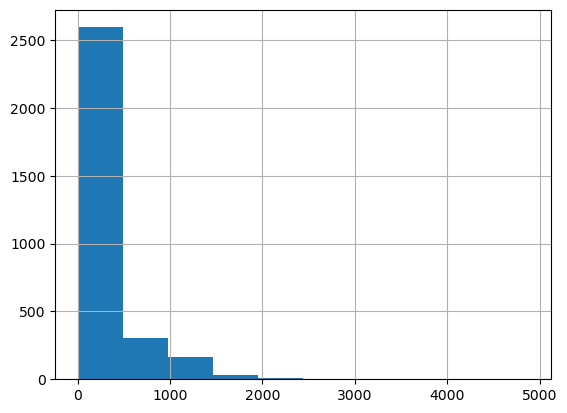

In [9]:
results["peak_list"]["total_intensity"].hist()

### View Interactive Results
User can explore the results in the GUI. By clicking pixels in the image(top left), users can view its mass spectrum(bottom middle), mobilogram(top right) and 2D spectogram combining these two(top middle). Also, users can click entries in the peak list(bottom left) to investigate ion images and spectral details of that peak. The menu(bottom right) provide summarizing functions like TIC image and mean spectrum, as well as file export options. This requires a living Python session to render, here shows a screenshot:

In [10]:
show(results['viz'])

### Separate ions by ion mobility 
Isobaric ions, or ions with non-distinguishable m/z(for example, isomers) could be separated by ion mobility. As examples shown below, TIMSImaging detected both peaks.

In [11]:
from bokeh.layouts import row

In [15]:
isomer1, _  = timsimaging.plotting.image(dataset, i=1079, results=results)
isomer2, _  = timsimaging.plotting.image(dataset, i=1080, results=results)
show(row(isomer1, isomer2))

<img src="isomer_screenshot_1.png" width="50%">

In [14]:
isomer1, _  = timsimaging.plotting.image(dataset, i=1163, results=results)
isomer2, _  = timsimaging.plotting.image(dataset, i=1164, results=results)
show(row(isomer1, isomer2))

<img src="isomer_screenshot_2.png" width="50%">

### Export the processed data in imzML format
Finally, we export the processed data as continuous, centroid imzML file for downstream analysis in Cardinal.

In [11]:
timsimaging.spectrum.export_imzML(dataset, path=r"D:/dataset/Kidney_MS1_ITO6", peaks=results)

100%|███████████████████████████████████████████████████████████████████████████| 22978/22978 [00:40<00:00, 572.90it/s]
